In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

Данные представляют из себя характеристики клиента страховой компании по которым нужно понять будет ли он заинтересован в страховке. Таким образом, страховая компания может более оптимально таргетить рекламу и выстраивать коммуникацию с клиентами, повышая конверсию.

**Описания колонок:**
- Gender - Male, Female
- Age - Возраст
- Driving_License - Наличие водительского удостоверения
- Region_Code - Область проживания
- Previously_Insured - Пользовался ли раньше услугами страховой компании
- Vehicle_Age - Возраст транспортного средства
- Vehicle_Damage - Попадало ли траспортное средство в ДТП
- Annual_Premium - Ежегодные выплаты клиента
- Policy_Sales_Channel - Политика распространения страховых услуг (через посредников, напрямую и т.д.)
- Vintage - Количество дней, в течение которых клиент был связан с компанией 


- **Response** - заинтересован в страховке 1, не откликнулся 0

In [6]:
data = pd.read_csv('vehicle_insurance.csv')

data

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,24,1,37.0,1,< 1 Year,No,21243.0,152.0,21,0
9996,Male,28,1,35.0,1,< 1 Year,No,23589.0,160.0,173,0
9997,Female,27,1,15.0,0,< 1 Year,Yes,33340.0,152.0,207,0
9998,Female,28,1,14.0,1,< 1 Year,No,25426.0,152.0,247,0


Проведем небольшой EDA. Посмотрим на распределения некоторых колонок, на матрицу корреляций. Также проверим баланс классов и посмотрим на распределение возраста транспортного средства в зависимости от response. \
Закодируем признаки типа `object` с помощью `one-hot` кодирования.

P.S. некоторые не `object` колонки по смыслу очевидно являются категориальными. Так как мы будем строить ансамбли на основе деревьев, их можно оставить в первоначальном виде.

<AxesSubplot:xlabel='Policy_Sales_Channel', ylabel='Density'>

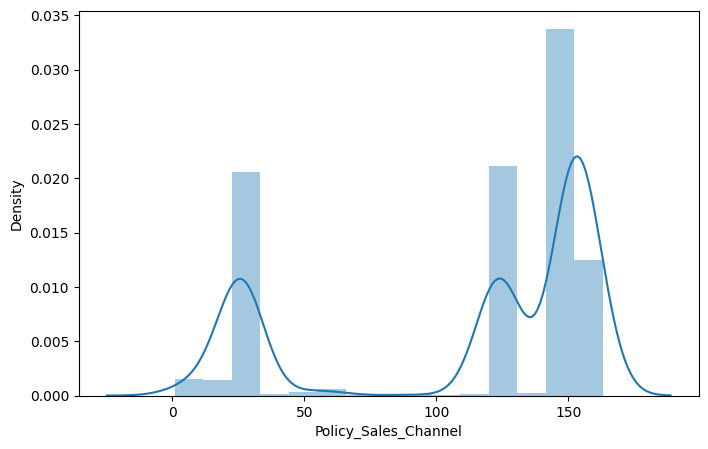

In [7]:

sns.distplot(data['Policy_Sales_Channel'])


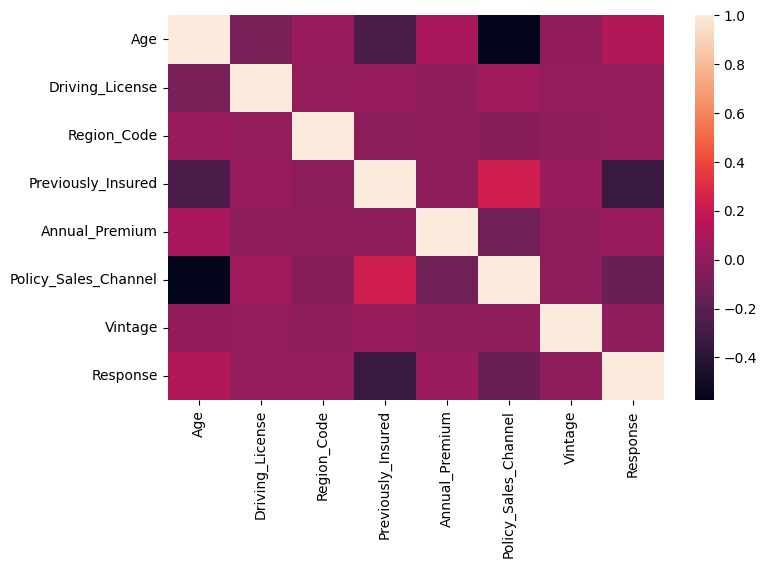

In [8]:
sns.heatmap(data.corr());

In [9]:
data['Response'].value_counts(True)

0    0.8753
1    0.1247
Name: Response, dtype: float64

In [10]:
### сохраним текущую форму датасета

data_copy = data.copy()

In [11]:
### Проведем Mean Target Encoding

data = pd.get_dummies(data, drop_first=True)
data.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,1,28.0,0,40454.0,26.0,217,1,1,0,1,1
1,76,1,3.0,0,33536.0,26.0,183,0,1,0,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,1,0,1,1
3,21,1,11.0,1,28619.0,152.0,203,0,1,1,0,0
4,29,1,41.0,1,27496.0,152.0,39,0,0,1,0,0


Обучим градиентный бустинг из sklearn на данных и замерим accuracy и f1-score на тестовой выборке. В качестве параметров ансамбля установим `learning_rate = 1`, `random_state = 1`, `n_estimators = 100`. Изобразим ROC-кривую и посчитаем AUC, оценим качество классификации. 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X = data.drop('Response', axis=1)
y = data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(learning_rate = 1, random_state = 1, n_estimators = 100)
model.fit(X_train, y_train)
y_true = y_test
y_pred = model.predict(X_test)
print(classification_report(y_true, y_pred, labels = [0, 1]))



              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1770
           1       0.31      0.24      0.27       230

    accuracy                           0.85      2000
   macro avg       0.61      0.59      0.59      2000
weighted avg       0.84      0.85      0.84      2000



0.828


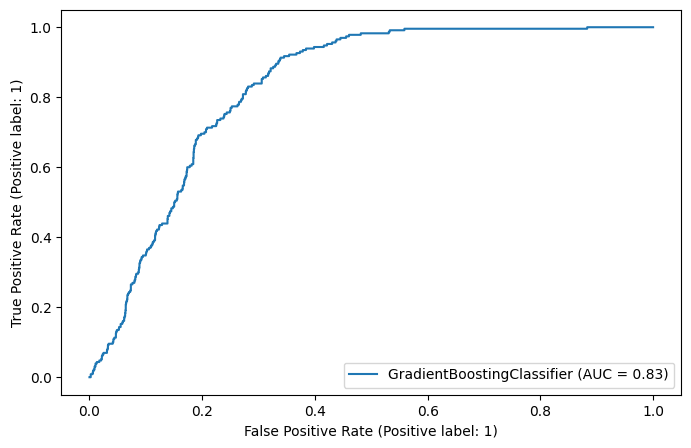

In [14]:
from sklearn.metrics import RocCurveDisplay
roc = RocCurveDisplay.from_estimator(model, X_test, y_test)
print(round(roc.roc_auc, 3))

Переберем параметры `n_estimators` и `learning_rate` по двумерной сетке. При обучении в цикле сразу считаем f1-score на тестовой выборке и сохраняем результат в матрицу. 

Построим кривые для метрики f1-score в зависимости от числа шагов для нескольких learning_rate. Изобразим heatmap полученной матрицы.



In [15]:
### Задаем сетку параметров

n_estimators_list = [5, 10, 20, 50, 100, 200, 700, 1000]
learning_rate_list = [1, 0.1, 0.01]
f1_matrix = np.zeros((len(n_estimators_list), len(learning_rate_list)))

for (i, n) in enumerate(n_estimators_list):
    for (j, lr) in enumerate(learning_rate_list):
        model = GradientBoostingClassifier(n_estimators=n,
                                           learning_rate=lr,
                                           max_depth=5,
                                           random_state=1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Суём в матрицу
        f1_matrix[i, j] = f1_score(y_test, y_pred, average='weighted')
        
print(f1_matrix)

f1_dataframe = pd.DataFrame(f1_matrix, 
                            index=map(str, n_estimators_list), 
                            columns=map(str, learning_rate_list))

[[0.83598325 0.83197068 0.83100796]
 [0.83840034 0.83197068 0.83100796]
 [0.84418229 0.83171715 0.83100796]
 [0.83603288 0.83162689 0.83222411]
 [0.83748981 0.83772792 0.83197068]
 [0.84227999 0.84312432 0.83171715]
 [0.84333633 0.84268016 0.8348982 ]
 [0.84576272 0.84572434 0.83711097]]


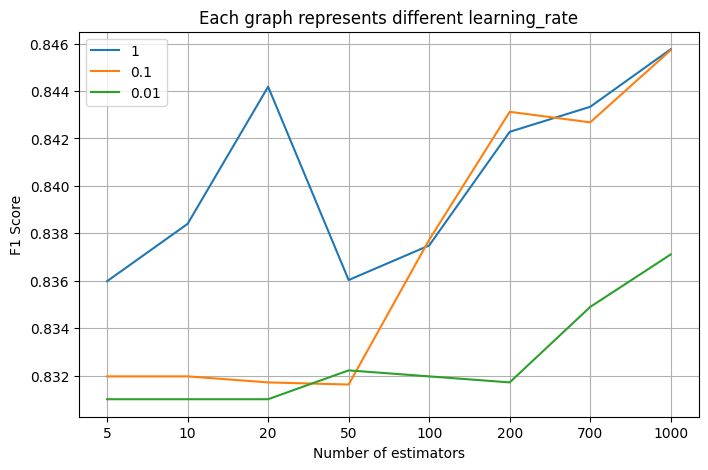

In [16]:

### Строим обучающие кривые

plt.plot(f1_dataframe)

plt.title('Each graph represents different learning_rate')
plt.xlabel('Number of estimators')
plt.ylabel('F1 Score')

plt.grid()
plt.legend(learning_rate_list);



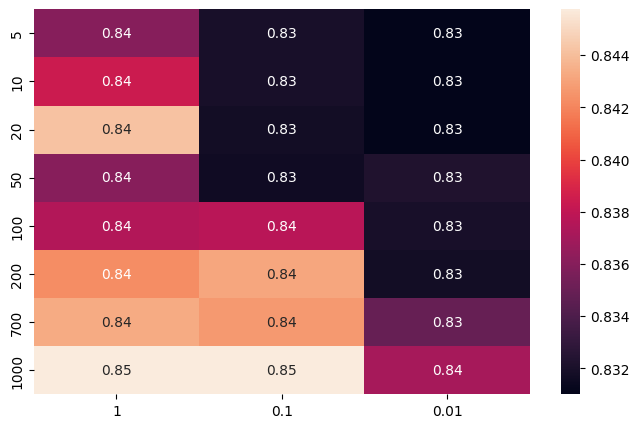

In [17]:
### Построим карту с качеством для наборов параметров

sns.heatmap(f1_dataframe, annot=True);

In [18]:
model = GradientBoostingClassifier(learning_rate=1,
                                   n_estimators=1000,
                                   random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9049    0.9249    0.9148      1770
           1     0.3037    0.2522    0.2755       230

    accuracy                         0.8475      2000
   macro avg     0.6043    0.5885    0.5952      2000
weighted avg     0.8358    0.8475    0.8413      2000



Попробуем обучить 4 модели и посчитать метрику f1-score на тестовой и обучающей выборках для каждой модели. 
1. Случайный лес с максимальной глубиной деревьев 5,
2. Случайный лес с максимальной глубиной деревьев 5000,
3. Градиентный бустинг с максимальной глубиной деревьев 5,
4. Градиентный бустинг с максимальной глубиной деревьев 5000.

Для каждой модели переберем значения `n_estimators`. Отрисуем графики зависимости f1-score от количества шагов, используя `average='weighted'` для учёта баланса классов. 


In [19]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]


In [20]:
### Обучим на заданных параметрах различные модели

n_estimators_list = [2, 3, 4, 5, 10, 20, 50, 70, 100, 200, 700, 1000, 2000]
f1_matrix = np.zeros((len(n_estimators_list), 8))

for (j, max_depth) in enumerate([5, 5000]):
    for (i, n) in enumerate(n_estimators_list):

        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    random_state=1)
        rf.fit(X_train, y_train)
        rf_pred_test, rf_pred_train = rf.predict(X_test), rf.predict(X_train)

        lgb = GradientBoostingClassifier(n_estimators=n,
                                         max_depth=max_depth,
                                         random_state=1)
        lgb.fit(X_train, y_train)
        lgb_pred_test, lgb_pred_train = lgb.predict(X_test), lgb.predict(X_train)
        
        f1_matrix[i, j*4:j*4+4] = (f1_score(y_test, rf_pred_test, average='weighted'),
                                   f1_score(y_train, rf_pred_train, average='weighted'),
                                   f1_score(y_test, lgb_pred_test, average='weighted'),
                                   f1_score(y_train, lgb_pred_train, average='weighted'))
        
trees = list(map(str, n_estimators_list))

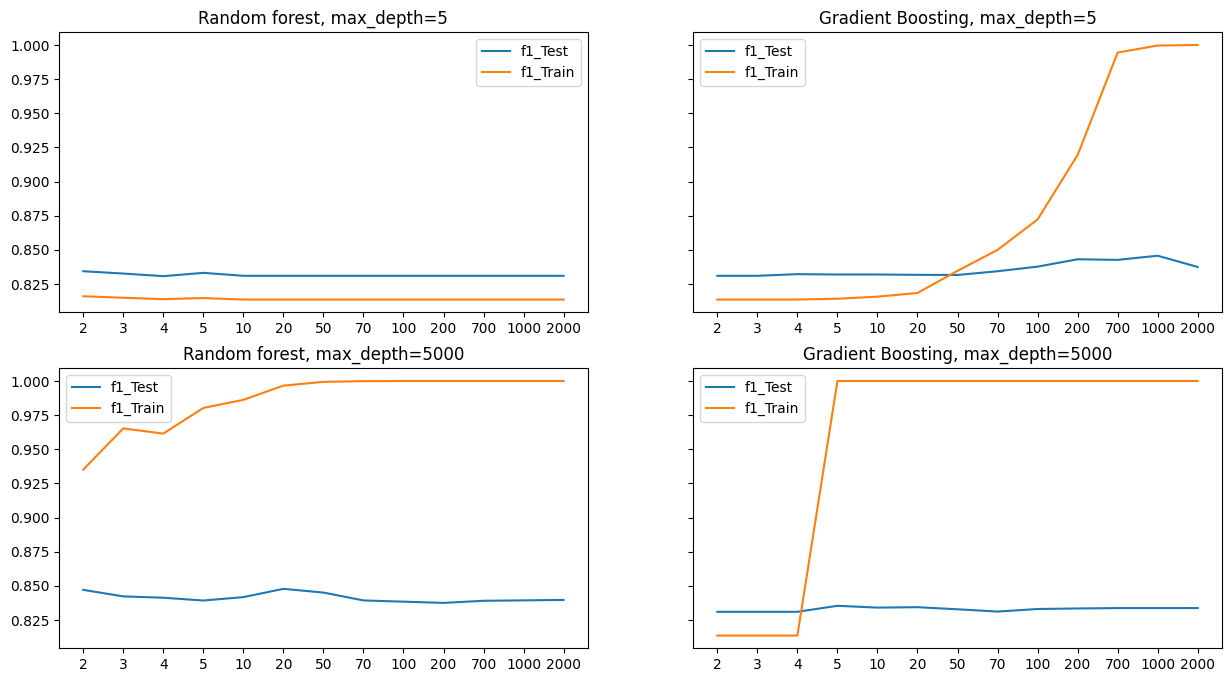

In [21]:
### Нарисуем обучающие кривые

fig, axs = plt.subplots(2, 2, figsize = (15, 8), sharey=True)

for (i, ax) in enumerate(axs.reshape(-1)):
    ax.plot(trees, f1_matrix[:, i*2], label = 'f1_Test')
    ax.plot(trees, f1_matrix[:, i*2+1], label = 'f1_Train')
    ax.legend()
    
axs[0, 0].set_title('Random forest, max_depth=5')
axs[1, 0].set_title('Random forest, max_depth=5000')

axs[0, 1].set_title('Gradient Boosting, max_depth=5')
axs[1, 1].set_title('Gradient Boosting, max_depth=5000');

Установим библиотеку `catboost`. Главной особенностью catboost явялется наличие встроенной обработки категориальных признаков. Для каждого категориального столбца вычисляется следующее значение
$$
avg\_target = \dfrac{countInClass + prior}{totalCount + 1},
$$
* countInClass - количество объектов положительного класса для данной категории **до текущего объекта**,
* prior - некоторая константа для числителя, обычно равна доле положительного класса в таргете,
* totalCount - количество наблюдаемых категорий вплоть **до текущего** с той же категорией, что и у текущего.

Так как первые такие значения будут иметь больший разброс, чем последние, то выборку перемешивают несколько раз и полученные статистики усредняют. 
В отличие от target encoder подсчитанные значения зависят от наблюдаемой истории, т.е. вычисляются только из наблюдений до них, таким образом не происходит target leakage. 

Обучим CatBoostClassifier с дефолтными параметрами. Используем  датасет до  (разобьем на train/test по старой логике с тем же random state'ом). Категориальные колонки передадим в параметр `cat_features` метода `fit`.

Сравним качество с предыдущей моделью

Сравним feature importances в модели раньше и в catboost с помощью соответствующих методов, изобразите их, используя `barplot`. 

In [22]:
from catboost import CatBoostClassifier

X = data_copy.drop('Response', axis=1)
y = data_copy['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

cboost = CatBoostClassifier(verbose=0)

cboost.fit(X_train,
           y_train,
           cat_features=['Gender', 'Vehicle_Age', 'Vehicle_Damage'])

y_pred = cboost.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8891    0.9870    0.9355      1770
           1     0.3429    0.0522    0.0906       230

    accuracy                         0.8795      2000
   macro avg     0.6160    0.5196    0.5130      2000
weighted avg     0.8262    0.8795    0.8383      2000



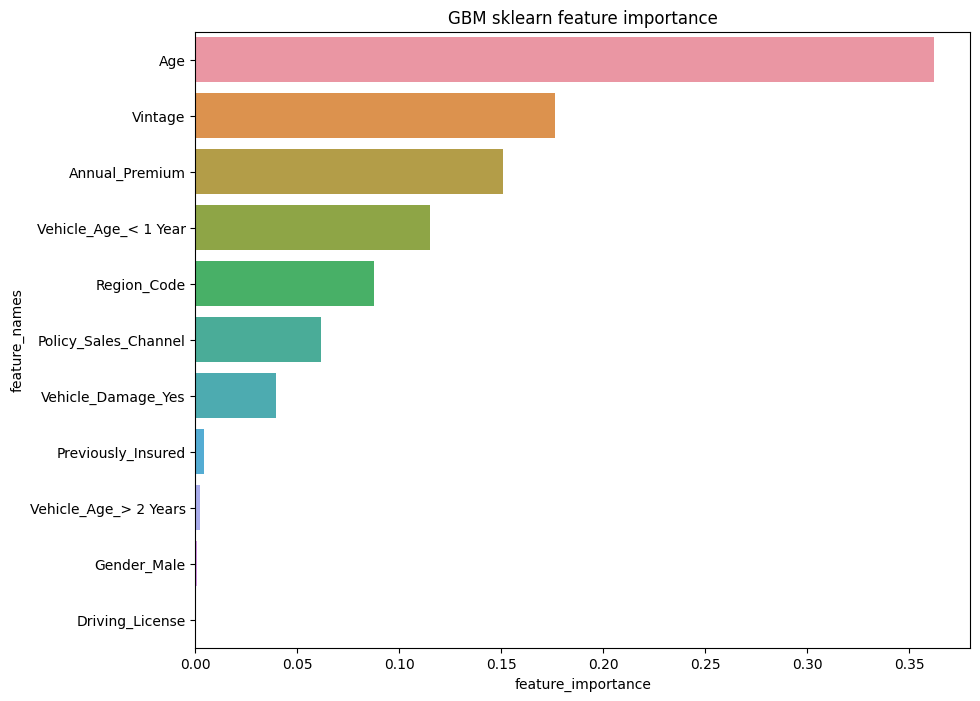

In [25]:
### Какие признаки оказались наиболее важны в model?

fi_df = pd.DataFrame({'feature_names': data.columns.drop('Response'),
                      'feature_importance': model.feature_importances_})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('GBM sklearn feature importance');

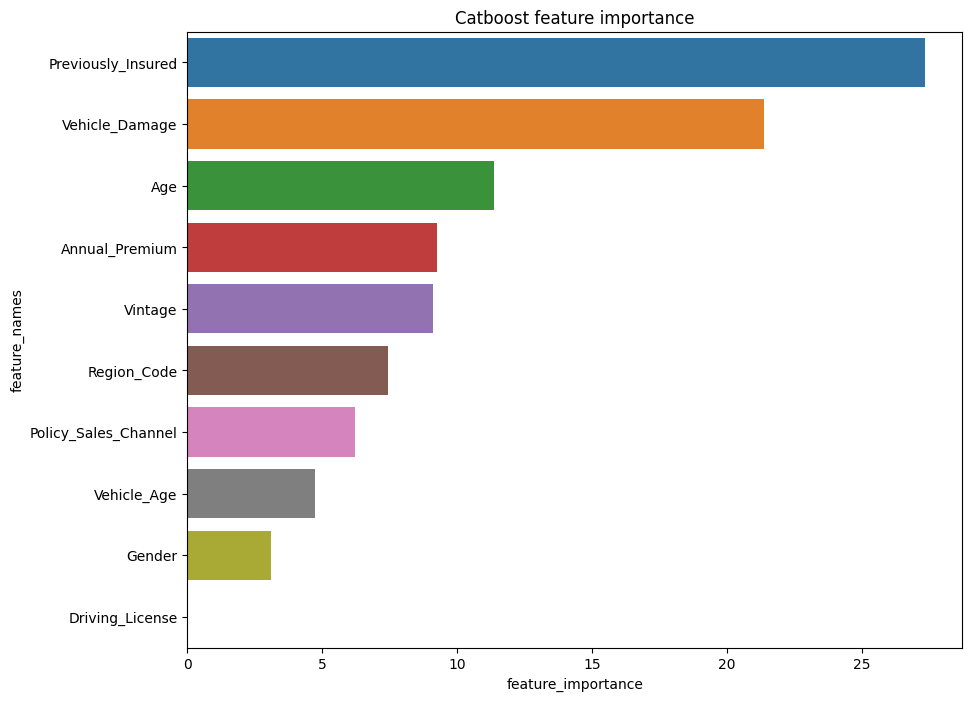

In [24]:
### А в катбусте?

fi_df = pd.DataFrame({'feature_names': data_copy.columns.drop('Response'),
                      'feature_importance': cboost.get_feature_importance()})

plt.figure(figsize=(10,8))
sns.barplot(x='feature_importance', y='feature_names', 
            data=fi_df.sort_values('feature_importance', ascending=False))
plt.title('Catboost feature importance');